In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#importing the libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
#importing & reading the dataset
base_dataset= pd.read_csv(r"C:\Users\Saquib Shaikh\Downloads\day.csv")
base_dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


**After observing the dataset in excel & reading the data dictionary we can make the following observations about it**
1. Date column is in the DD/MM/YYYY format which is of no use in python so we will be splitting it into 3 columns 
2. Instant column can be dropped.
3. Season is a categorical variable but it is in a wrong format
4. Weekday assigns a numeric value to each day of the week starting from 0---Sunday ending 6---Saturday
5. Casual and registered together make up the cnt column which is our dependent variable.
   Note that these 2 columns cannot be used as they have a very high correlation with each other as 
   they sum up and form the cnt column.

In [4]:
#checking the number of rows and columns 
base_dataset.shape

(730, 16)

In [5]:
#checking if dataset has null values 
base_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


**We can see from above output that pandas library is reading the categorical variables like season, month, weathersit as numerical values and this cannot be the case as it will affect our model**

**Hence, first we typecast these columns to string type and convert them into categorical columns which we can interpret later after the model is built**

In [6]:
 base_dataset.loc[(base_dataset['season']==1),'season'] = 'spring' #assigning string values to spring season as per data dictionary

In [7]:
base_dataset.loc[(base_dataset['season']==2),'season'] = 'summer'
base_dataset.loc[(base_dataset['season']==3),'season'] = 'fall'
base_dataset.loc[(base_dataset['season']==4),'season'] = 'winter' ##replicating above code to assign string value to seasons column       

In [8]:
base_dataset['season'].value_counts() ##checking whether all seasons are converted 

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

In [9]:
base_dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [10]:
base_dataset['mnth'].value_counts()

1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: mnth, dtype: int64

Month column also needs to be converted into appropriate string values as pandas might consider it as numerical data and cause problems in the model building 

In [11]:
#We define a function to map values 1 to 12 to Jan to Dec and pply it to the month column
def monthmap(x):
    return x.map({1:'Jan',2:'Feb',3:'March',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
base_dataset[['mnth']] = base_dataset[['mnth']].apply(monthmap)
base_dataset.head()                            ##checking the conversions

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,Jan,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,Jan,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,Jan,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,Jan,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,Jan,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [12]:
##Also need to convert values in weekday to the proper catwgorical string values, same code can be used
def weekmap(x):
     return x.map({1:'mon',2:'tues',3:'wed',4:'thurs',5:'fri',6:'sat',0:'sun'})
base_dataset[['weekday']] = base_dataset[['weekday']].apply(weekmap) 

In [13]:
base_dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,Jan,0,sat,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,Jan,0,sun,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,Jan,0,mon,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,Jan,0,tues,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,Jan,0,wed,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Weathersit column meaning is as follows
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

We replace these 1,2,3,4 Numeric values by A,B,C,D

In [14]:
def weathermap(x):
    return x.map({1:'A',2:'B',3:'C',4:'D'}) #define a function to apply values
base_dataset[['weathersit']] = base_dataset[['weathersit']].apply(weathermap) 

base_dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,Jan,0,sat,0,B,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,Jan,0,sun,0,B,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,Jan,0,mon,1,A,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,Jan,0,tues,1,A,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,Jan,0,wed,1,A,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [15]:
base_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    object 
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    object 
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    object 
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    object 
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(7), object(5)
memory usage: 91.4+ KB


# Data Visualization and EDA

In [16]:
!pip install sweetviz


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\Saquib Shaikh\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


In [17]:
import sweetviz as sv

In [18]:
sweet_report = sv.analyze(base_dataset)
sweet_report.show_html('sweet_report.html')

                                             |                                             | [  0%]   00:00 ->…

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


---Here we have generated a HTML file using sweetviz package that does EDA and shows us the report. 

---After analyzing and studying the report in detail we can conclude that 

**Alternatively we can use the traditional boxplots and histograms to visualize data and draw conclusions from same**

<Figure size 1200x600 with 0 Axes>

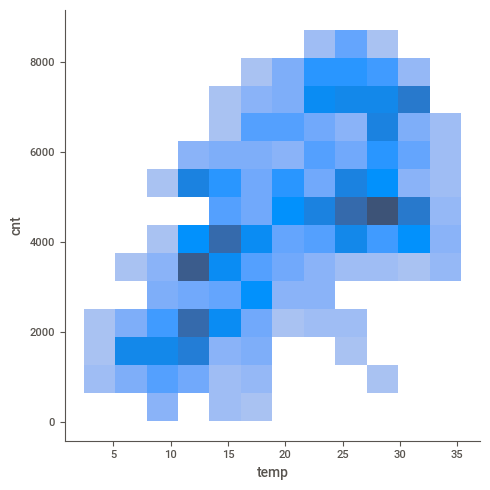

In [19]:
#visualizing the numerical variable temperature
plt.figure(figsize=(12,6))
sns.displot(base_dataset,x='temp',y='cnt')
plt.show()

<Figure size 1200x600 with 0 Axes>

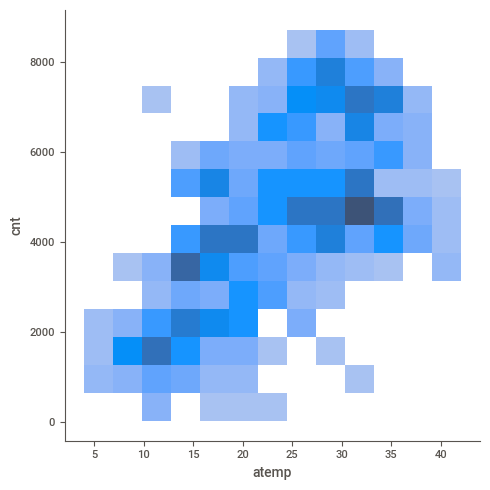

In [20]:
#visualizing the numerical variable atemp
plt.figure(figsize=(12,6))
sns.displot(base_dataset,x='atemp',y='cnt')
plt.show()

<Figure size 1200x600 with 0 Axes>

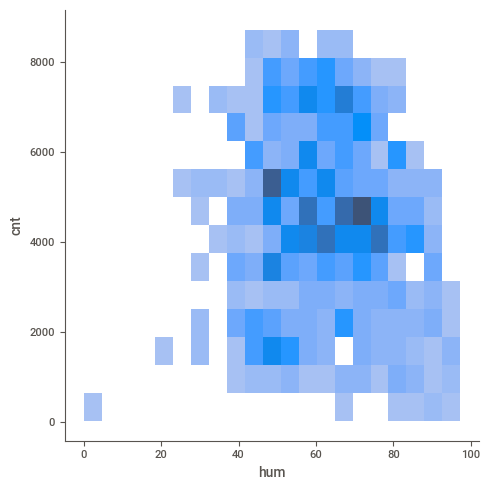

In [21]:
#visualizing the numerical variable humidity
plt.figure(figsize=(12,6))
sns.displot(base_dataset,x='hum',y='cnt')
plt.show()

<Figure size 1200x600 with 0 Axes>

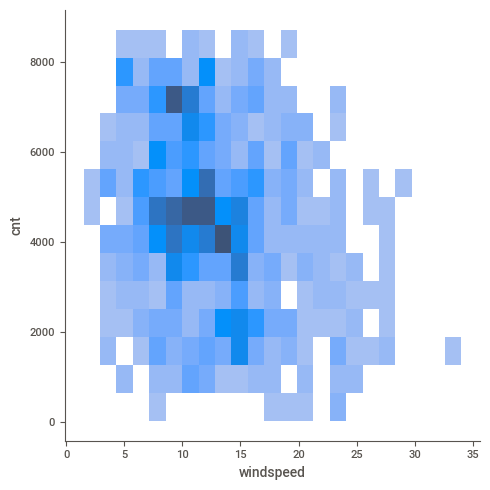

In [22]:
#visualizing the numerical variable windspeed
plt.figure(figsize=(12,6))
sns.displot(base_dataset,x='windspeed',y='cnt')
plt.show()

#### Finally for numerical variables, after visualizing using graphs and also sweetviz report we can plot a correlation matrix to find exact correlation between.

In [23]:
##dropping the instant column as it is redundant 
base_dataset=base_dataset.drop(columns='instant')
base_dataset.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,01-01-2018,spring,0,Jan,0,sat,0,B,14.110847,18.18125,80.5833,10.749882,331,654,985
1,02-01-2018,spring,0,Jan,0,sun,0,B,14.902598,17.68695,69.6087,16.652113,131,670,801
2,03-01-2018,spring,0,Jan,0,mon,1,A,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,04-01-2018,spring,0,Jan,0,tues,1,A,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,05-01-2018,spring,0,Jan,0,wed,1,A,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [24]:
cor = base_dataset.corr()
cor

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt
yr,1.000000,0.008195,-0.002945,0.048789,0.047215,-0.112547,-0.011624,0.250502,0.596911,0.569728
holiday,0.008195,1.000000,-0.252948,-0.028764,-0.032703,-0.015662,0.006257,0.054055,-0.109142,-0.068764
workingday,-0.002945,-0.252948,1.000000,0.053470,0.052940,0.023202,-0.018666,-0.517607,0.305437,0.062542
temp,0.048789,-0.028764,0.053470,1.000000,0.991696,0.128565,-0.158186,0.542731,0.539436,0.627044
atemp,0.047215,-0.032703,0.052940,0.991696,1.000000,0.141512,-0.183876,0.543362,0.543678,0.630685
hum,-0.112547,-0.015662,0.023202,0.128565,0.141512,1.000000,-0.248506,-0.075211,-0.089212,-0.098543
windspeed,-0.011624,0.006257,-0.018666,-0.158186,-0.183876,-0.248506,1.000000,-0.167995,-0.217914,-0.235132
casual,0.250502,0.054055,-0.517607,0.542731,0.543362,-0.075211,-0.167995,1.000000,0.394137,0.672123
registered,0.596911,-0.109142,0.305437,0.539436,0.543678,-0.089212,-0.217914,0.394137,1.000000,0.945411
cnt,0.569728,-0.068764,0.062542,0.627044,0.630685,-0.098543,-0.235132,0.672123,0.945411,1.000000


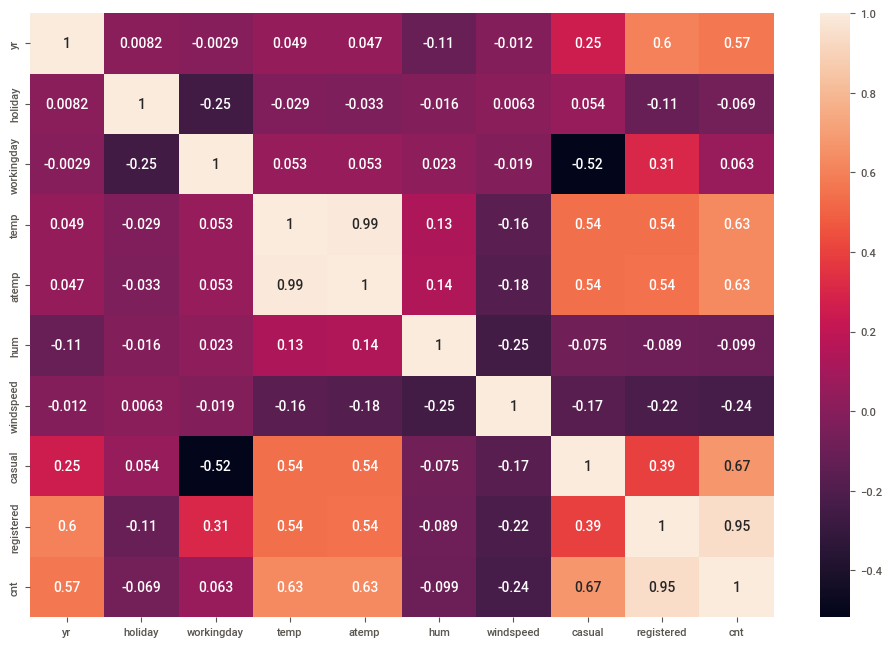

In [25]:
#we can plot the correlation matrix for better visualizing and understanding 
plt.figure(figsize=(12,8))
sns.heatmap(cor,annot=True)
plt.show()

**FOR THE CATEGORICAL VARIABLES WE USE BOXPLOTS TO VISUALIZE HOW RELATIONSHIPS ARE VARYING**

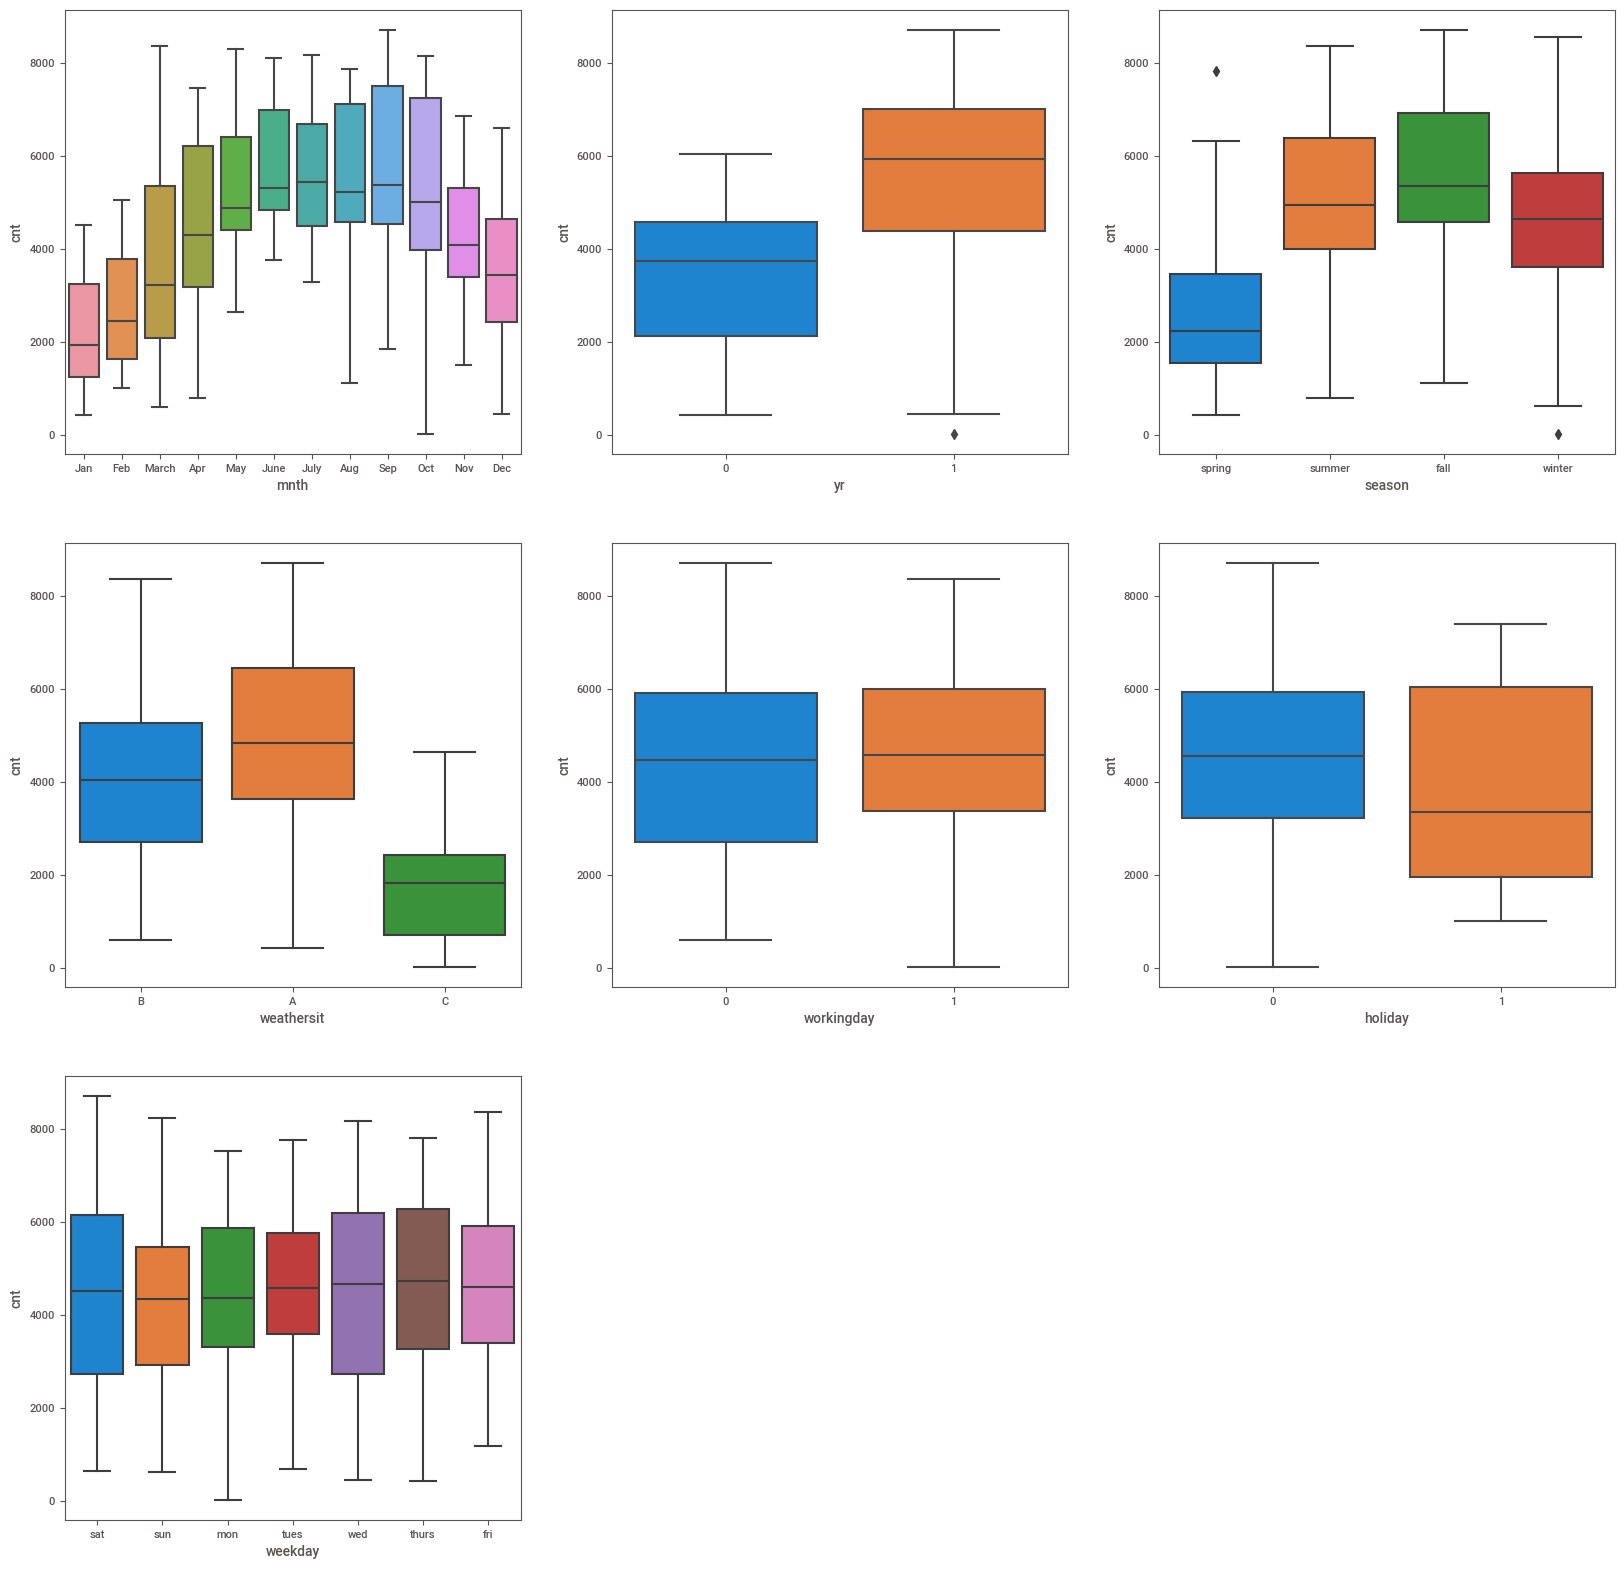

In [26]:
plt.figure(figsize = (20,20))
plt.subplot(3,3,1)
sns.boxplot(x='mnth',y='cnt',data = base_dataset)
plt.subplot(3,3,2)
sns.boxplot(x='yr',y='cnt',data = base_dataset)
plt.subplot(3,3,3)
sns.boxplot(x='season',y='cnt',data=base_dataset)
plt.subplot(3,3,4)
sns.boxplot(x='weathersit',y='cnt',data=base_dataset)
plt.subplot(3,3,5)
sns.boxplot(x='workingday',y='cnt',data = base_dataset)
plt.subplot(3,3,6)
sns.boxplot(x='holiday',y='cnt',data = base_dataset)
plt.subplot(3,3,7)
sns.boxplot(x='weekday',y='cnt',data = base_dataset)
plt.show() 
##plotting the categorical variables to study how they changw with dependent variable cnt

### From our EDA on categorical variables we can conclude the following points

##### Atemp and temp are highly correlated with each other, almost =1 so to avoid multicollinearity we drop the atemp column
##### Season is a good variable, can be used in the model as we see the demand increases during the fall and summer seasons.
##### There isn't much to gain from weekday as the median is almost same through all days sp demand is not really changing much with days pf the week.
##### Same can be concluded about holiday as there isn't a significant change in demand on the holidays 
##### Also weekday is not affecting the demand much. 

In [27]:
base_dataset.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,01-01-2018,spring,0,Jan,0,sat,0,B,14.110847,18.18125,80.5833,10.749882,331,654,985
1,02-01-2018,spring,0,Jan,0,sun,0,B,14.902598,17.68695,69.6087,16.652113,131,670,801
2,03-01-2018,spring,0,Jan,0,mon,1,A,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,04-01-2018,spring,0,Jan,0,tues,1,A,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,05-01-2018,spring,0,Jan,0,wed,1,A,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [28]:
##dropping the atemp column
base_dataset=base_dataset.drop(columns='atemp')
base_dataset.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,01-01-2018,spring,0,Jan,0,sat,0,B,14.110847,80.5833,10.749882,331,654,985
1,02-01-2018,spring,0,Jan,0,sun,0,B,14.902598,69.6087,16.652113,131,670,801
2,03-01-2018,spring,0,Jan,0,mon,1,A,8.050924,43.7273,16.636703,120,1229,1349
3,04-01-2018,spring,0,Jan,0,tues,1,A,8.200000,59.0435,10.739832,108,1454,1562
4,05-01-2018,spring,0,Jan,0,wed,1,A,9.305237,43.6957,12.522300,82,1518,1600


## Data preparation & Model building

**Dummy Variables encoding for columns like yr, mnth, holiday, weekday**

In [29]:
binary_vars = ['season','mnth','weekday','weathersit']
base_dummies = pd.get_dummies(base_dataset[binary_vars],drop_first=True)
base_dummies.head()

,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_July,mnth_June,mnth_March,...,mnth_Oct,mnth_Sep,weekday_mon,weekday_sat,weekday_sun,weekday_thurs,weekday_tues,weekday_wed,weathersit_B,weathersit_C
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [30]:
base_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    object 
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    object 
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    object 
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    object 
 8   temp        730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  casual      730 non-null    int64  
 12  registered  730 non-null    int64  
 13  cnt         730 non-null    int64  
dtypes: float64(3), int64(6), object(5)
memory usage: 80.0+ KB


In [31]:
##droppinf dteday column
base_dataset = base_dataset.drop(columns = 'dteday')
base_dataset.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,spring,0,Jan,0,sat,0,B,14.110847,80.5833,10.749882,331,654,985
1,spring,0,Jan,0,sun,0,B,14.902598,69.6087,16.652113,131,670,801
2,spring,0,Jan,0,mon,1,A,8.050924,43.7273,16.636703,120,1229,1349
3,spring,0,Jan,0,tues,1,A,8.200000,59.0435,10.739832,108,1454,1562
4,spring,0,Jan,0,wed,1,A,9.305237,43.6957,12.522300,82,1518,1600


In [32]:
base_dataset = base_dataset.drop(binary_vars,axis=1)
base_dataset=pd.concat([base_dataset,base_dummies])
base_dataset.head()

,yr,holiday,workingday,temp,hum,windspeed,casual,registered,cnt,season_spring,...,mnth_Oct,mnth_Sep,weekday_mon,weekday_sat,weekday_sun,weekday_thurs,weekday_tues,weekday_wed,weathersit_B,weathersit_C
0,0.0,0.0,0.0,14.110847,80.5833,10.749882,331.0,654.0,985.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,14.902598,69.6087,16.652113,131.0,670.0,801.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,1.0,8.050924,43.7273,16.636703,120.0,1229.0,1349.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,1.0,8.200000,59.0435,10.739832,108.0,1454.0,1562.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,1.0,9.305237,43.6957,12.522300,82.0,1518.0,1600.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Model building

In [34]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(base_dataset, train_size = 0.7, random_state= 100)

In [35]:
df_train

,yr,holiday,workingday,temp,hum,windspeed,casual,registered,cnt,season_spring,...,mnth_Oct,mnth_Sep,weekday_mon,weekday_sat,weekday_sun,weekday_thurs,weekday_tues,weekday_wed,weathersit_B,weathersit_C
318,0.0,0.0,1.0,21.730000,68.8750,13.375411,449.0,3746.0,4195.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,0.0,0.0,0.0,28.989419,56.1765,20.412153,1415.0,2919.0,4334.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
390,1.0,0.0,1.0,14.008347,76.9583,4.917519,244.0,3831.0,4075.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,0.0,0.0,1.0,9.091299,42.3043,6.305571,139.0,1778.0,1917.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350,0.0,0.0,0.0,10.591653,56.0833,16.292189,275.0,2464.0,2739.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,0.0,0.0,1.0,17.647835,73.7391,19.348461,401.0,1676.0,2077.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
df_test

,yr,holiday,workingday,temp,hum,windspeed,casual,registered,cnt,season_spring,...,mnth_Oct,mnth_Sep,weekday_mon,weekday_sat,weekday_sun,weekday_thurs,weekday_tues,weekday_wed,weathersit_B,weathersit_C
706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
57,0.0,0.0,0.0,14.082598,68.0000,8.391616,694.0,1708.0,2402.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
382,1.0,0.0,1.0,12.436653,44.3333,27.833743,109.0,3267.0,3376.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,1.0,0.0,1.0,29.554153,66.7500,10.166379,954.0,5336.0,6290.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399,1.0,0.0,0.0,10.830847,77.9583,8.167032,384.0,2448.0,2832.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
545,1.0,0.0,0.0,31.365000,60.1250,10.791757,1455.0,4232.0,5687.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266,0.0,0.0,0.0,24.873347,86.2500,5.251681,1776.0,3647.0,5423.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Scaling 

Scaling the numerical variables temp, hum, windspeed, casual, registered and count  

In [36]:
num_vars = ['temp','windspeed','hum','casual','registered','cnt']

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [41]:
df_train.describe() #checking to see our scaling has been done

,yr,holiday,workingday,temp,hum,windspeed,casual,registered,cnt,season_spring,...,mnth_Oct,mnth_Sep,weekday_mon,weekday_sat,weekday_sun,weekday_thurs,weekday_tues,weekday_wed,weathersit_B,weathersit_C
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,517.000000,...,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,0.501984,0.027778,0.676587,0.546980,0.644995,0.350710,0.265876,0.523746,0.536434,0.237911,...,0.087041,0.077369,0.139265,0.129594,0.156673,0.148936,0.141199,0.143133,0.350097,0.021277
std,0.500493,0.164499,0.468243,0.230935,0.146060,0.163134,0.215161,0.229018,0.234645,0.426217,...,0.282168,0.267436,0.346558,0.336181,0.363844,0.356370,0.348564,0.350548,0.477462,0.144445
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.348395,0.536311,0.228222,0.097154,0.352512,0.367998,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.537996,0.647815,0.333792,0.223538,0.521224,0.536606,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.754494,0.750750,0.442296,0.349692,0.689323,0.718231,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [55]:
#replacing the nan values with zero
X_train = X_train.fillna(0)

In [56]:
X_train.head()

,yr,holiday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_Aug,...,mnth_Oct,mnth_Sep,weekday_mon,weekday_sat,weekday_sun,weekday_thurs,weekday_tues,weekday_wed,weathersit_B,weathersit_C
318,0.0,0.0,1.0,0.596010,0.708226,0.365392,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
239,0.0,0.0,0.0,0.820125,0.577650,0.581909,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
686,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
390,1.0,0.0,1.0,0.357625,0.791345,0.105148,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
##splitting the taining set into X & y i.e dependent variable and predictor variables 
y = df_train.pop('cnt')
X = df_train.drop(['casual','registered'],axis = 1)

In [57]:
y_train = y_train.fillna(0)
y_train.head()

318    0.498388
239    0.514989
256    0.000000
686    0.000000
390    0.484056
Name: cnt, dtype: float64

In [52]:
y_train = y

In [53]:
X_train = X #because we forgot to name it properly

### Building the Linear Model using ScikitLearn

In [58]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [59]:
lr.coef_

array([ 0.25202077, -0.09444864,  0.01417138,  0.64182297, -0.11497169,
       -0.15615419, -0.08586386, -0.12379238, -0.0461448 , -0.1596368 ,
       -0.09932396, -0.07348995, -0.07261572, -0.15871908, -0.0807135 ,
       -0.05994975, -0.03440276, -0.11245558, -0.11075291, -0.1460294 ,
       -0.02147615, -0.02285421, -0.02045284, -0.02164535, -0.02033567,
       -0.01882697, -0.00295312, -0.00671378])

In [60]:
lr.intercept_

0.17766951127797476

In [61]:
print("Training data score is")
print(lr.score(X_train,y_train))

Training data score is
0.9231345005863627


In [62]:
##trying out the model using gradient boosting regressor 
##this is not part of the case study as it has more degrees than linear model.
from sklearn.ensemble import GradientBoostingRegressor
lr = GradientBoostingRegressor()
lr.fit(X_train,y_train)
print("Training data score is")
print(lr.score(X_train,y_train))

Training data score is
0.9802974527146467


### Modelling using Statsmodels 

In [64]:
!pip install statsmodels


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\Saquib Shaikh\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip



     ---------------------------------------- 9.2/9.2 MB 901.3 kB/s eta 0:00:00
     -------------------------------------- 233.8/233.8 kB 1.2 MB/s eta 0:00:00


In [65]:
import statsmodels.api as sm

In [67]:
X_train_sm = sm.add_constant(X_train)

lr = sm.OLS(y_train,X_train_sm).fit()

TypeError: 'Series' object is not callable

In [68]:
lr.params   ##checking the constants and intercepts

const            0.177670
yr               0.252021
holiday         -0.094449
workingday       0.014171
temp             0.641823
hum             -0.114972
windspeed       -0.156154
season_spring   -0.085864
season_summer   -0.123792
season_winter   -0.046145
mnth_Aug        -0.159637
mnth_Dec        -0.099324
mnth_Feb        -0.073490
mnth_Jan        -0.072616
mnth_July       -0.158719
mnth_June       -0.080714
mnth_March      -0.059950
mnth_May        -0.034403
mnth_Nov        -0.112456
mnth_Oct        -0.110753
mnth_Sep        -0.146029
weekday_mon     -0.021476
weekday_sat     -0.022854
weekday_sun     -0.020453
weekday_thurs   -0.021645
weekday_tues    -0.020336
weekday_wed     -0.018827
weathersit_B    -0.002953
weathersit_C    -0.006714
dtype: float64

In [69]:
lr.summary()  ##checking the adjusted R-squared and R-squared values for the model 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     425.5
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:23:42   Log-Likelihood:                 1041.4
No. Observations:                1021   AIC:                            -2025.
Df Residuals:                     992   BIC:                            -1882.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1777      0.020      9.092      0.000       0.139       0.216
yr                0.2520      0.008     32.040      0.000       0.237       0.267
holiday          -0.0944      0.025     -3.825      0.000      -0.143      -0.046
workingday        0.0142      0.009      1.641      0.101      -0.003       0.031
temp              0.6418      0.017     37.420      0.000       0.608       0.675
hum              -0.1150      0.024     -4.702      0.000      -0.163      -0.067
windspeed        -0.1562      0.024     -6.643      0.000      -0.202      -0.110
season_spring    -0.0859      0.028     -3.110      0.002      -0.140      -0.032
season_summer    -0.1238      0.020     -6.298      0.000      -0.162      -0.085
season_winter    -0.0461      0.026     -1.769      0.077      -0.097       0.005
mnth_Aug         -0.1596      0.024     -6.641      0.000      -0.207      -0.112
mnth_Dec         -0.0993      0.029     -3.399      0.001      -0.157      -0.042
mnth_Feb         -0.0735      0.030     -2.424      0.016      -0.133      -0.014
mnth_Jan         -0.0726      0.030     -2.441      0.015      -0.131      -0.014
mnth_July        -0.1587      0.024     -6.481      0.000      -0.207      -0.111
mnth_June        -0.0807      0.018     -4.410      0.000      -0.117      -0.045
mnth_March       -0.0599      0.024     -2.538      0.011      -0.106      -0.014
mnth_May         -0.0344      0.018     -1.960      0.050      -0.069    4.12e-05
mnth_Nov         -0.1125      0.032     -3.514      0.000      -0.175      -0.050
mnth_Oct         -0.1108      0.032     -3.473      0.001      -0.173      -0.048
mnth_Sep         -0.1460      0.024     -6.058      0.000      -0.193      -0.099
weekday_mon      -0.0215      0.015     -1.474      0.141      -0.050       0.007
weekday_sat      -0.0229      0.015     -1.544      0.123      -0.052       0.006
weekday_sun      -0.0205      0.014     -1.439      0.151      -0.048       0.007
weekday_thurs    -0.0216      0.014     -1.516      0.130      -0.050       0.006
weekday_tues     -0.0203      0.015     -1.399      0.162      -0.049       0.008
weekday_wed      -0.0188      0.015     -1.292      0.197      -0.047       0.010
weathersit_B     -0.0030      0.009     -0.346      0.729      -0.020       0.014
weathersit_C     -0.0067      0.028     -0.242      0.809      -0.061       0.048
==============================================================================
Omnibus:                      147.493   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              733.517
Skew:                          -0.561   Prob(JB):                    5.23e-160
Kurtosis:                       6.998   Cond. No.                         31.4
================================================================

###### From the above model we get the adjusted R Squared as 92% which is a pretty decent score. But we still have all the variables and some of them might be causing the score to drop as by definition Adjusted R-Squared penalizes the models for more variables. 

###### Also note that P values of certain variables which represent significance of those are quite high which means there is a feasibility to remove them

###### So we can drop some variables and try to check if our Adjusted R squared increases for the model 

###### We do this by using the method called as Recursive Feature Elimination 

### Building the model using RFE

In [73]:
##fitting the model with 15 variables 
from sklearn.feature_selection import RFE
lr = LinearRegression()
rfe = RFE(lr,  n_features_to_select = 15, step = 1)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [76]:
print(rfe.ranking_)
print(rfe.support_) ##checking the number of features and their ranking and whether RFE supports them in the model

[ 1  1 12  1  1  1  1  1  1  1  1  2  3  1  1  4  5  1  1  1  8  6 10  7
  9 11 14 13]
[ True  True False  True  True  True  True  True  True  True  True False
 False  True  True False False  True  True  True False False False False
 False False False False]


In [77]:
col1 = X_train.columns[rfe.support_]
X_train_rfe = X_train[col1]
#adding constant 
X_train_rfe = sm.add_constant(X_train_rfe)
X_train_rfe.head()

,const,yr,holiday,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_July,mnth_June,mnth_Nov,mnth_Oct,mnth_Sep
318,1.0,0.0,0.0,0.596010,0.708226,0.365392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
239,1.0,0.0,0.0,0.820125,0.577650,0.581909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
686,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
390,1.0,1.0,0.0,0.357625,0.791345,0.105148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
lr1 = sm.OLS(y_train,X_train_rfe).fit()

#checking the adjusted r2
lr1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     789.8
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:01:11   Log-Likelihood:                 1032.6
No. Observations:                1021   AIC:                            -2033.
Df Residuals:                    1005   BIC:                            -1954.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1531      0.018      8.640      0.000       0.118       0.188
yr                0.2546      0.008     32.406      0.000       0.239       0.270
holiday          -0.1024      0.024     -4.259      0.000      -0.150      -0.055
temp              0.6519      0.017     38.350      0.000       0.618       0.685
hum              -0.0844      0.023     -3.615      0.000      -0.130      -0.039
windspeed        -0.1358      0.023     -5.901      0.000      -0.181      -0.091
season_spring    -0.1474      0.019     -7.769      0.000      -0.185      -0.110
season_summer    -0.1409      0.018     -7.749      0.000      -0.177      -0.105
season_winter    -0.0788      0.024     -3.323      0.001      -0.125      -0.032
mnth_Aug         -0.1531      0.022     -6.867      0.000      -0.197      -0.109
mnth_Dec         -0.0540      0.022     -2.474      0.014      -0.097      -0.011
mnth_July        -0.1531      0.023     -6.741      0.000      -0.198      -0.109
mnth_June        -0.0625      0.016     -3.828      0.000      -0.094      -0.030
mnth_Nov         -0.0743      0.027     -2.731      0.006      -0.128      -0.021
mnth_Oct         -0.0743      0.027     -2.754      0.006      -0.127      -0.021
mnth_Sep         -0.1314      0.022     -6.099      0.000      -0.174      -0.089
==============================================================================
Omnibus:                      149.560   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              741.849
Skew:                          -0.573   Prob(JB):                    8.12e-162
Kurtosis:                       7.016   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We observe that Adjusted R2 is the same for 15 variables 

Lets run use a vif function here to check out which of these 15 columns might have a very high correlation with others so we can drop that and again check if our r2 changes 

In [80]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
a = X_train_rfe.drop('const',axis=1)

In [82]:
#create a dataframe that will contain all features in one column and respective vif in another 
vif = pd.DataFrame()
vif['features'] = a.columns
vif['vif'] = [variance_inflation_factor(a.values,i) for i in range(a.shape[1])]
vif = vif.sort_values(by='vif', ascending = False)
vif

,features,vif
3,hum,8.105902
7,season_winter,7.851452
2,temp,6.089545
4,windspeed,3.908579
13,mnth_Oct,3.738878
12,mnth_Nov,3.556287
9,mnth_Dec,2.448636
0,yr,1.926208
14,mnth_Sep,1.184113
6,season_summer,1.142689


We can conclude from above data that humidity has a very high VIF value of 8.1 as against our threshold of 5. Let's drop the humidity column from our dataframe and check again

In [84]:
a = a.drop(columns='hum',axis = 1)
a

,yr,holiday,temp,windspeed,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_July,mnth_June,mnth_Nov,mnth_Oct,mnth_Sep
318,0.0,0.0,0.596010,0.365392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
239,0.0,0.0,0.820125,0.581909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
686,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
390,1.0,0.0,0.357625,0.105148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,0.0,0.0,0.205824,0.147857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
350,0.0,0.0,0.252144,0.455140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.469984,0.549180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
vif = pd.DataFrame()
vif['features'] = a.columns
vif['vif'] = [variance_inflation_factor(a.values,i) for i in range(a.shape[1])]
vif = vif.sort_values(by='vif', ascending = False)
vif

,features,vif
6,season_winter,7.851452
12,mnth_Oct,3.738878
11,mnth_Nov,3.556287
2,temp,3.173549
3,windspeed,2.973947
8,mnth_Dec,2.448636
0,yr,1.900945
13,mnth_Sep,1.184113
5,season_summer,1.142689
10,mnth_June,1.142689


**We can see that after dropping the humidity column the VIF for temperature column goes down significantly from 7.85 to 3.17, which indicates it was highly collinear with temperature column**

Lets drop the season_winter column now and check vif again

In [86]:
##dropping the season_winter column from dataframe
a = a.drop(columns='season_winter',axis = 1)
a

,yr,holiday,temp,windspeed,season_spring,season_summer,mnth_Aug,mnth_Dec,mnth_July,mnth_June,mnth_Nov,mnth_Oct,mnth_Sep
318,0.0,0.0,0.596010,0.365392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
239,0.0,0.0,0.820125,0.581909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
686,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
390,1.0,0.0,0.357625,0.105148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,0.0,0.0,0.205824,0.147857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
350,0.0,0.0,0.252144,0.455140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.469984,0.549180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
##agin checking the VIF 
vif = pd.DataFrame()
vif['features'] = a.columns
vif['vif'] = [variance_inflation_factor(a.values,i) for i in range(a.shape[1])]
vif = vif.sort_values(by='vif', ascending = False)
vif

,features,vif
2,temp,3.173549
3,windspeed,2.973947
0,yr,1.900945
5,season_summer,1.142689
9,mnth_June,1.142689
4,season_spring,1.032233
7,mnth_Dec,1.032233
1,holiday,1.025563
6,mnth_Aug,1.000000
8,mnth_July,1.000000


**WE CAN CONCLUDE FROM ABOVE DATAFRAME THAT ALL OUR REMAINING VARIABLES ARE GOOD TO GO FOR THE MODEL, LET'S BUILD THE MODEL USING THESE VARIABLES AND CHECK THE CHANGE IN R2 AGAIN**

In [104]:
X_train_rfe2 = X_train_rfe.drop(columns=['hum','season_winter'])

In [107]:
##adding a constant to a=our data 
X_train_rfe2 = sm.add_constant(X_train_rfe2)

In [108]:
lr1 = sm.OLS(y_train,X_train_rfe2).fit()

#checking the adjusted r2
lr1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     894.7
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:12:06   Log-Likelihood:                 1023.0
No. Observations:                1021   AIC:                            -2018.
Df Residuals:                    1007   BIC:                            -1949.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1000      0.012      8.029      0.000       0.076       0.124
yr                0.2568      0.008     32.482      0.000       0.241       0.272
holiday          -0.1007      0.024     -4.155      0.000      -0.148      -0.053
temp              0.6406      0.016     40.106      0.000       0.609       0.672
windspeed        -0.1239      0.023     -5.435      0.000      -0.169      -0.079
season_spring    -0.0923      0.014     -6.538      0.000      -0.120      -0.065
season_summer    -0.0921      0.014     -6.555      0.000      -0.120      -0.064
mnth_Aug         -0.1000      0.018     -5.413      0.000      -0.136      -0.064
mnth_Dec         -0.0727      0.016     -4.427      0.000      -0.105      -0.040
mnth_July        -0.1000      0.019     -5.268      0.000      -0.137      -0.063
mnth_June        -0.0408      0.016     -2.615      0.009      -0.071      -0.010
mnth_Nov         -0.1000      0.019     -5.378      0.000      -0.136      -0.064
mnth_Oct         -0.1000      0.018     -5.480      0.000      -0.136      -0.064
mnth_Sep         -0.1000      0.019     -5.306      0.000      -0.137      -0.063
==============================================================================
Omnibus:                      163.597   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              881.805
Skew:                          -0.614   Prob(JB):                    3.30e-192
Kurtosis:                       7.384   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

----We observe that the adjusted R2 is dropped from 95% to 91%, but the P-values for all the variables now are 0 which indicate they're all significant and even though our R-squared has decreased, the interpretability of the model would be better for business purposes

### Residual Analysis 

In [109]:
##plotting the residuals for the training sets
y_train_pred = lr1.predict(X_train_rfe2)

In [98]:
y_train_pred

318    4.364913e-01
239    5.532200e-01
256    1.526557e-15
686    1.304512e-15
390    5.728016e-01
           ...     
72     7.685285e-03
53     2.135067e-01
350    2.050931e-01
79     3.329826e-01
62     7.685285e-03
Length: 1021, dtype: float64

<AxesSubplot: ylabel='Density'>

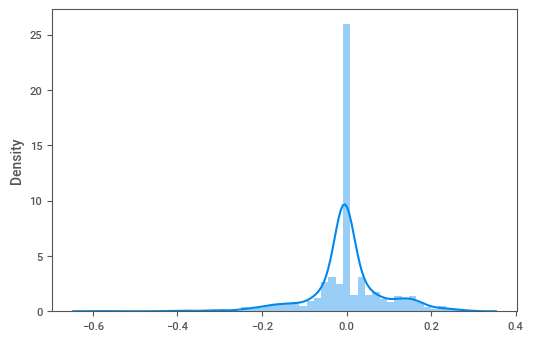

In [110]:
residuals = y_train - y_train_pred
sns.distplot(residuals)

#### We observe that the residuals are normally distributed and centered around mean 0. which is what we wanted to verify so let's move ahead with making predictions 

### On basis of above mentioned information, we finalize this model lr1 and make predictions using this model

### Making predictions on the test set

In [93]:
##first make the same scaling on the test set that we have done on the training set 
##we only transform the test set using the scaler from training set and then split into X_test and y_test
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [95]:
y_test = df_test.pop('cnt')
X_test = df_test.drop(columns=['casual','registered'],axis = 1)

In [96]:
X_test = X_test.fillna(0)
y_test = y_test.fillna(0)

In [111]:
X_test.head()

,yr,holiday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_Aug,...,mnth_Oct,mnth_Sep,weekday_mon,weekday_sat,weekday_sun,weekday_thurs,weekday_tues,weekday_wed,weathersit_B,weathersit_C
706,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
57,0.0,0.0,0.0,0.359917,0.699229,0.212044,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
382,1.0,0.0,1.0,0.309103,0.455869,0.810267,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
440,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [118]:
col = a.columns
col = col.drop('const')
col

Index(['yr', 'holiday', 'temp', 'windspeed', 'season_spring', 'season_summer',
       'mnth_Aug', 'mnth_Dec', 'mnth_July', 'mnth_June', 'mnth_Nov',
       'mnth_Oct', 'mnth_Sep'],
      dtype='object')

In [119]:
##subsetting these columns and creating new dataframe 
X_test_rfe2 = X_test[col]

In [120]:
X_test_rfe2.shape

(439, 13)

In [122]:
X_test_rfe2 = sm.add_constant(X_test_rfe2)

In [123]:
y_test_pred = lr1.predict(X_test_rfe2)

Text(0, 0.5, 'y_test_pred')

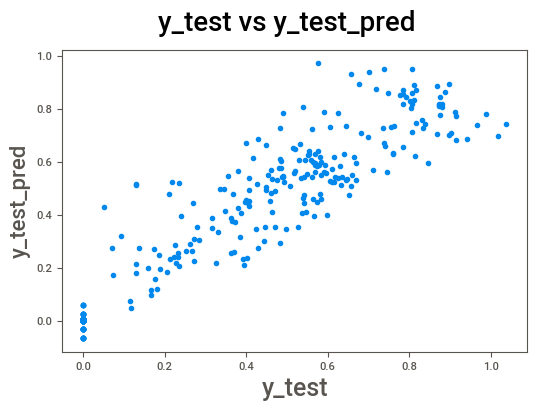

In [124]:
##plotting the y_test and y_pred
fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_test_pred', fontsize = 16)  

From above model we can see that the model is doing well on the test set as well as there is a linear distribution with minimum outliers

In [126]:
# r2_score for 14 variables
from sklearn.metrics import r2_score
r2_score(y_test, y_test_pred)

0.9083034323293904